## Векторные представления слов

### Лемматизация и стемминг

In [ ]:
!pip install razdel pymorphy2

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=811fbc1a6c489e7fa4d7c1b0d0cc28748a9ec85d5bd20f50d2a9ea20dbd5d75a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pandas as pd

from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

morph.parse('стекло')#[0].normal_form


# сущ - им.п, ед.ч.
# гл - неопр. форма
# прил - м.р, ед.ч

[Parse(word='стекло', tag=OpencorporaTag('NOUN,inan,neut sing,nomn'), normal_form='стекло', score=0.690476, methods_stack=((DictionaryAnalyzer(), 'стекло', 157, 0),)),
 Parse(word='стекло', tag=OpencorporaTag('NOUN,inan,neut sing,accs'), normal_form='стекло', score=0.285714, methods_stack=((DictionaryAnalyzer(), 'стекло', 157, 3),)),
 Parse(word='стекло', tag=OpencorporaTag('VERB,perf,intr neut,sing,past,indc'), normal_form='стечь', score=0.023809, methods_stack=((DictionaryAnalyzer(), 'стекло', 1015, 3),))]

In [ ]:
from pymystem3 import Mystem

_LEMMATIZER = Mystem()
processed = _LEMMATIZER.analyze('ывдвамлтоиаль')
processed

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


[{'analysis': [{'lex': 'ывдвамлтоиаль',
    'wt': 0.3837170269,
    'qual': 'bastard',
    'gr': 'S,жен,неод=(вин,ед|им,ед)'}],
  'text': 'ывдвамлтоиаль'},
 {'text': '\n'}]

In [ ]:
import razdel  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

from pymystem3 import Mystem
from pymorphy2 import MorphAnalyzer

_LEMMATIZER = None
def tag(word, mode='pymystem'):

    if mode == 'pymystem':
      _LEMMATIZER = Mystem()
      processed = _LEMMATIZER.analyze(word)[0]

      if not processed.get('analysis'):
          return word.strip().lower()
      else:
          processed = processed["analysis"][0]["lex"]

    elif mode == 'pymorphy':
      _LEMMATIZER = MorphAnalyzer()
      processed = _LEMMATIZER.parse(word)[0].normal_form

    return processed

import re
def tokenize_re_mystem(doc):
    return [tag(x, 'pymystem') for x in re.split('(\W+)', doc) if x.strip()]

def tokenize_morphy(doc):
    return [tag(t.text, 'pymorphy') for t in razdel.tokenize(doc)]


print(tokenize_re_mystem('Выплаты на второго ребёнка'))
print(tokenize_morphy('Выплаты на второго ребёнка'))

['выплата', 'на', 'второй', 'ребенок']
['выплата', 'на', 'второй', 'ребёнок']


In [ ]:
print(tokenize_re_mystem('Названы регионы России с\xa0самой высокой смертностью, от\xa0рака...'))
print(tokenize_morphy('Названы регионы России с\xa0самой высокой смертностью, от\xa0рака...'))

['называть', 'регион', 'россия', 'с', 'самый', 'высокий', 'смертность', ',', 'от', 'рак', '...']
['назвать', 'регион', 'россия', 'с', 'сам', 'высокий', 'смертность', ',', 'от', 'рак', '...']


In [ ]:
print(tokenize_re_mystem('Это всё-таки на 3,5 процента меньше, чем годом ранее.'))
print(tokenize_morphy('Это всё-таки на 3,5 процента меньше, чем годом ранее.'))

['это', 'все', '-', 'таки', 'на', '3', ',', '5', 'процент', 'мало', ',', 'что', 'год', 'ранее', '.']
['это', 'всё-таки', 'на', '3,5', 'процент', 'маленький', ',', 'чем', 'год', 'ранее', '.']


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
stopword_ru = stopwords.words('russian')


cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] удаление лишних символов
        [2] токенизация предложения через razdel
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)

    # [1]
    text = text.replace('\xa0', '')
    text = re.sub(r'[^а-яА-ЯёЁ ]', '', text)
    # [2]
    tokens = list(razdel.tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)

    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]

    return words_lem_without_stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


https://drive.google.com/file/d/1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx

In [ ]:
!wget 'https://drive.google.com/uc?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx' -O lenta.csv

--2024-10-17 12:35:50--  https://drive.google.com/uc?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx
Resolving drive.google.com (drive.google.com)... 173.194.203.139, 173.194.203.138, 173.194.203.102, ...
Connecting to drive.google.com (drive.google.com)|173.194.203.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx [following]
--2024-10-17 12:35:50--  https://drive.usercontent.google.com/download?id=1_nGNKblAmcaJ_rrx9ZU2FI7PIHxk8UDx
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.20.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3589533 (3.4M) [application/octet-stream]
Saving to: ‘lenta.csv’

lenta.csv           100%[===================>]   3.42M  --.-KB/s    in 0.02s   

2024-10-17 12:35:52 (198 MB/s) - ‘

In [ ]:
df = pd.read_csv('lenta.csv')
df.sample(5)

,title,class
22112,Европа перешла в наступление в торговой войне ...,Экономика
1285,В Дагестане удивились «убийствам чести» и пооб...,Россия
4792,Власти Подмосковья отчитались о выданных много...,Россия
1646,Кандидатка на «Мисс Вселенную» от Исландии ока...,Из жизни
15605,Российская фигуристка-чемпионка попала в аварию,Спорт


In [ ]:
id = 19678
df['title'][id]

'Неблагодарная обезьяна повалила ударом кормившую ее\xa0девочку'

In [ ]:
lemmatization(df['title'][id])

['неблагодарный', 'обезьяна', 'повалить', 'удар', 'кормить', 'еедевочка']

### Разбиение данных на обучение и тест

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df['title'], df['class'],
                                                  test_size=0.2,
                                                  stratify=df['class'],
                                                  random_state=42)

print(len(X_train), len(y_train), len(X_val), len(y_val))

23990 23990 5998 5998


In [ ]:
y_train.value_counts(normalize=True)

,proportion
class,
Россия,0.138766
Мир,0.137099
Спорт,0.109962
Экономика,0.101417
Интернет и СМИ,0.077782
Бывший СССР,0.069737
Из жизни,0.069696
Наука и техника,0.067695
Культура,0.063693


In [ ]:
y_val.value_counts(normalize=True)

,proportion
class,
Россия,0.138880
Мир,0.137212
Спорт,0.110037
Экономика,0.101534
Интернет и СМИ,0.077693
Бывший СССР,0.069690
Из жизни,0.069690
Наука и техника,0.067689
Культура,0.063688


### CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
TEST_ITEMS = {
    6: 'Это первое предложение. Это оно снова!',
    8: 'Это пример второго предложения',
    9: 'А это третье предложение'
}


vectorizer = CountVectorizer(
    analyzer='word',
    # ngram_range=(1, 2),
    # tokenizer=lemmatization,
    min_df=1)

vectorized = vectorizer.fit_transform(TEST_ITEMS.values())
vectorized

<3x9 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [ ]:
print(vectorized)

  (0, 8)	2
  (0, 2)	1
  (0, 3)	1
  (0, 1)	1
  (0, 6)	1
  (1, 8)	1
  (1, 5)	1
  (1, 0)	1
  (1, 4)	1
  (2, 8)	1
  (2, 3)	1
  (2, 7)	1


In [ ]:
vectorizer.get_feature_names_out()

array(['второго', 'оно', 'первое', 'предложение', 'предложения', 'пример',
       'снова', 'третье', 'это'], dtype=object)

In [ ]:
# выплата на ребенка
pd.DataFrame(vectorized.toarray(), columns=vectorizer.get_feature_names_out())

,второго,оно,первое,предложение,предложения,пример,снова,третье,это
0,0,1,1,1,0,0,1,0,2
1,1,0,0,0,1,1,0,0,1
2,0,0,0,1,0,0,0,1,1


In [ ]:
print("Vocabulary size:", len(vectorizer.vocabulary_))
vectorizer.vocabulary_

Vocabulary size: 9


{'это': 8,
 'первое': 2,
 'предложение': 3,
 'оно': 1,
 'снова': 6,
 'пример': 5,
 'второго': 0,
 'предложения': 4,
 'третье': 7}

In [ ]:
TEST_QUERY = ['первое предложение для примера!']
print("Test example:")

feats_example = vectorizer.transform(TEST_QUERY)
print(feats_example)
print("Test dense:")
print("Dense:")
pd.DataFrame(feats_example.toarray(), columns=vectorizer.get_feature_names_out())

Test example:
  (0, 2)	1
  (0, 3)	1
Test dense:
Dense:


,второго,оно,первое,предложение,предложения,пример,снова,третье,это
0,0,0,1,1,0,0,0,0,0


In [ ]:
vec_x = CountVectorizer(
    tokenizer=lemmatization,
    min_df=2
)
vec_x.fit_transform(X_train)

print(vec_x.get_feature_names_out()[:10])
print("Vocabulary size:", len(vec_x.vocabulary_))

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['аборт' 'абрамович' 'абсолютный' 'абсурдный' 'абхазия' 'авангард'
 'аварийный' 'авария' 'августовский' 'авиабаза']
Vocabulary size: 11361


In [ ]:
train_x_vec = vec_x.transform(X_train)
val_x_vec = vec_x.transform(X_val)

In [ ]:
train_x_vec

<23990x11361 sparse matrix of type '<class 'numpy.int64'>'
	with 127416 stored elements in Compressed Sparse Row format>

In [ ]:
pd.DataFrame(train_x_vec.toarray(), columns=vec_x.get_feature_names_out())

,аборт,абрамович,абсолютный,абсурдный,абхазия,авангард,аварийный,авария,августовский,авиабаза,...,ярославль,ярославский,яростный,ярость,ярошенко,яхта,яхтсмен,ячейка,ящик,ёж
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23985,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23986,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23987,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23988,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
23990 * 11361

272550390

#### Модель

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(
    random_state=0
)
clf.fit(train_x_vec, y_train)

CPU times: user 9.59 s, sys: 3.35 s, total: 12.9 s
Wall time: 7.77 s


LogisticRegression(random_state=0)

In [ ]:
predict_val = clf.predict(val_x_vec)
pd.DataFrame(zip(predict_val, y_val, X_val), columns=['predicted', 'expected', 'title'])

,predicted,expected,title
0,Россия,Мир,«Ответственный» учитель избивал школьника за н...
1,Экономика,Бывший СССР,Додона задумали оставить без работы
2,Силовые структуры,Силовые структуры,От взрыва у здания ФСБ в Архангельске пострада...
3,Интернет и СМИ,Интернет и СМИ,Грузная телеведущая в прямом эфире столкнула а...
4,Россия,Россия,Власти Подмосковья рассказали о бесплатных пут...
...,...,...,...
5993,Экономика,Экономика,Названа стоимость реконструкции «Лужников»
5994,Культура,Бывший СССР,Умер автор «Акта провозглашения независимости ...
5995,Спорт,Интернет и СМИ,Бургер под названием Huevo Grande сочли оскорб...
5996,Россия,Культура,Русские школьники воздвигли мемориал XXXTentac...


In [ ]:
clf.score(train_x_vec, y_train), clf.score(val_x_vec, y_val)

(0.929137140475198, 0.7264088029343114)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
print(classification_report(predict_val, y_val, digits=3))

                   precision    recall  f1-score   support

   69-я параллель      0.333     0.889     0.485        18
      Бывший СССР      0.773     0.790     0.781       409
              Дом      0.739     0.845     0.788       194
         Из жизни      0.706     0.629     0.665       469
   Интернет и СМИ      0.633     0.691     0.661       427
         Культура      0.733     0.773     0.753       362
              Мир      0.801     0.712     0.754       925
  Наука и техника      0.749     0.707     0.727       430
      Путешествия      0.539     0.769     0.634       117
           Россия      0.707     0.633     0.668       931
Силовые структуры      0.579     0.679     0.625       274
            Спорт      0.885     0.905     0.895       645
         Ценности      0.627     0.742     0.680       190
        Экономика      0.708     0.710     0.709       607

         accuracy                          0.726      5998
        macro avg      0.679     0.748     0.702      

In [ ]:
print(confusion_matrix(predict_val, y_val))

[[ 16   0   0   0   0   0   0   0   0   1   1   0   0   0]
 [  0 323   0   2  12   8   8   8   3  18   4   7   0  16]
 [  0   1 164   1   3   0   3   0   1   7   5   1   2   6]
 [  6   2   7 295  40  10  36   9   8  19   7   6  18   6]
 [  1   6   3  25 295  14  15   9   6  17  10   9   8   9]
 [  2   8   1   8  10 280   4   4   1  10   9   5  15   5]
 [  1  17   4  33  33  19 659  33  13  44  22   8   7  32]
 [  3   6   2  11   7   8  24 304   4  17   5   6   8  25]
 [  2   4   1   2   0   1   4   1  90   6   1   0   1   4]
 [ 11  21  22  16  29  16  38  14  20 589  60  21   9  65]
 [  0   8   5   4   6   5   9   0   1  44 186   3   1   2]
 [  1   3   3   7  11   4   3   2   5   9   2 584   7   4]
 [  1   4   0   8   7   9   0   4   4   5   1   2 141   4]
 [  4  15  10   6  13   8  20  18  11  47   8   8   8 431]]


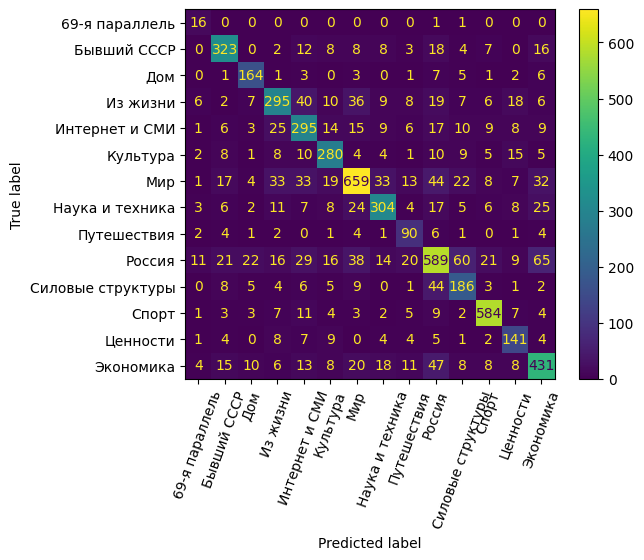

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

classes = y_train.unique()
disp = ConfusionMatrixDisplay.from_predictions(predict_val, y_val)
plt.xticks(rotation=70);

### TfidfVectorizer

In [ ]:
TEST_ITEMS = {
    6: 'Это первое предложение. Это оно снова!',
    8: 'Это пример второго предложения',
    9: 'А это третье предложение'
}

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    tokenizer=lemmatization,
    min_df=1)

vectorized = vectorizer.fit_transform(TEST_ITEMS.values())
vectorized

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


<3x18 sparse matrix of type '<class 'numpy.float64'>'
	with 22 stored elements in Compressed Sparse Row format>

In [ ]:
print(vectorized)

  (0, 13)	0.3784108624318652
  (0, 4)	0.320352642409885
  (0, 6)	0.1892054312159326
  (0, 2)	0.320352642409885
  (0, 10)	0.320352642409885
  (0, 15)	0.320352642409885
  (0, 5)	0.320352642409885
  (0, 7)	0.320352642409885
  (0, 14)	0.320352642409885
  (0, 3)	0.320352642409885
  (1, 13)	0.24743277305481848
  (1, 6)	0.24743277305481848
  (1, 8)	0.4189401020758947
  (1, 0)	0.4189401020758947
  (1, 16)	0.4189401020758947
  (1, 9)	0.4189401020758947
  (1, 1)	0.4189401020758947
  (2, 13)	0.3071440505460478
  (2, 6)	0.3071440505460478
  (2, 11)	0.5200400832078022
  (2, 17)	0.5200400832078022
  (2, 12)	0.5200400832078022


In [ ]:
pd.Series(vectorizer.idf_, index=vectorizer.get_feature_names_out()).sort_values()

,0
это,1.000000
предложение,1.000000
второй,1.693147
это первый,1.693147
это оно,1.693147
третий предложение,1.693147
третий,1.693147
снова,1.693147
пример второй,1.693147
пример,1.693147


In [ ]:
vectorizer.get_feature_names_out()

array(['второй', 'второй предложение', 'оно', 'оно снова', 'первый',
       'первый предложение', 'предложение', 'предложение это', 'пример',
       'пример второй', 'снова', 'третий', 'третий предложение', 'это',
       'это оно', 'это первый', 'это пример', 'это третий'], dtype=object)

In [ ]:
pd.DataFrame(vectorized.toarray(), columns=vectorizer.get_feature_names_out())

,второй,второй предложение,оно,оно снова,первый,первый предложение,предложение,предложение это,пример,пример второй,снова,третий,третий предложение,это,это оно,это первый,это пример,это третий
0,0.00000,0.00000,0.320353,0.320353,0.320353,0.320353,0.189205,0.320353,0.00000,0.00000,0.320353,0.00000,0.00000,0.378411,0.320353,0.320353,0.00000,0.00000
1,0.41894,0.41894,0.000000,0.000000,0.000000,0.000000,0.247433,0.000000,0.41894,0.41894,0.000000,0.00000,0.00000,0.247433,0.000000,0.000000,0.41894,0.00000
2,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.307144,0.000000,0.00000,0.00000,0.000000,0.52004,0.52004,0.307144,0.000000,0.000000,0.00000,0.52004


In [ ]:
print("Vocabulary size:", len(vectorizer.vocabulary_))
vectorizer.vocabulary_

Vocabulary size: 18


{'это': 13,
 'первый': 4,
 'предложение': 6,
 'оно': 2,
 'снова': 10,
 'это первый': 15,
 'первый предложение': 5,
 'предложение это': 7,
 'это оно': 14,
 'оно снова': 3,
 'пример': 8,
 'второй': 0,
 'это пример': 16,
 'пример второй': 9,
 'второй предложение': 1,
 'третий': 11,
 'это третий': 17,
 'третий предложение': 12}

In [ ]:
TEST_QUERY = ['первое предложение для примера!']
print("Test example:")

feats_example = vectorizer.transform(TEST_QUERY)
print(feats_example)
print("Test dense:")
print("Dense:")
pd.DataFrame(feats_example.toarray(), columns=vectorizer.get_feature_names_out())

Test example:
  (0, 4)	0.546454011634009
  (0, 5)	0.546454011634009
  (0, 6)	0.3227445421804912
  (0, 8)	0.546454011634009
Test dense:
Dense:


,второй,второй предложение,оно,оно снова,первый,первый предложение,предложение,предложение это,пример,пример второй,снова,третий,третий предложение,это,это оно,это первый,это пример,это третий
0,0.0,0.0,0.0,0.0,0.546454,0.546454,0.322745,0.0,0.546454,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 🧠 Упражнение. TfidfVectorizer

1. Создайте и обучите две модели TfIdf с параметрами:
* без лемматизации, с количеством токенов 10000
* с лемматизацией, с количеством токенов 10000

In [ ]:
vec_x_lem = TfidfVectorizer(
    ...
)
vec_x_lem.fit(X_train)

print("Vocabulary size:", len(vec_x_lem.vocabulary_))

train_x_vec_lem = ...
val_x_vec_lem = ...

train_x_vec_lem

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulary size: 10000


<23990x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 124693 stored elements in Compressed Sparse Row format>

In [ ]:
vec_x_no_lem = TfidfVectorizer(
    ...
)
vec_x_no_lem.fit(X_train)

print("Vocabulary size:", len(vec_x_no_lem.vocabulary_))

train_x_vec_no_lem = ...
val_x_vec_no_lem = ...

train_x_vec_no_lem

Vocabulary size: 10000


<23990x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 128287 stored elements in Compressed Sparse Row format>

2. Обучите две модели логистическая регрессия на двух преобразованных данных

Оцените метрику f1_macro

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf_lem = LogisticRegression()
...

CPU times: user 8.7 s, sys: 2.97 s, total: 11.7 s
Wall time: 6 s


LogisticRegression()

In [ ]:
pred_train = ...
pred_val = ...

f1_score(...), f1_score(...)

(0.8049759382607741, 0.6639204618389328)

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf_no_lem = LogisticRegression()
...

CPU times: user 9.57 s, sys: 3.04 s, total: 12.6 s
Wall time: 7.69 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
pred_train = ...
pred_val = ...

f1_score(...), f1_score(...)

(0.7908682590915295, 0.6231184776452722)

#### 🧠 Упражнение (ответ). TfidfVectorizer

1. Создайте и обучите две модели TfIdf с параметрами:
* без лемматизации, с количеством токенов 10000
* с лемматизацией, с количеством токенов 10000

In [ ]:
vec_x_lem = TfidfVectorizer(
    tokenizer=lemmatization,
    max_features=10000
)
vec_x_lem.fit(X_train)

print("Vocabulary size:", len(vec_x_lem.vocabulary_))

train_x_vec_lem = vec_x_lem.transform(X_train)
val_x_vec_lem = vec_x_lem.transform(X_val)

train_x_vec_lem

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Vocabulary size: 10000


<23990x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 124693 stored elements in Compressed Sparse Row format>

In [ ]:
vec_x_no_lem = TfidfVectorizer(
    # tokenizer=lemmatization,
    max_features=10000
)
vec_x_no_lem.fit(X_train)

print("Vocabulary size:", len(vec_x_no_lem.vocabulary_))

train_x_vec_no_lem = vec_x_no_lem.transform(X_train)
val_x_vec_no_lem = vec_x_no_lem.transform(X_val)

train_x_vec_no_lem

Vocabulary size: 10000


<23990x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 128287 stored elements in Compressed Sparse Row format>

2. Обучите две модели логистическая регрессия на двух преобразованных данных

Оцените метрику f1_macro

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf_lem = LogisticRegression()
clf_lem.fit(train_x_vec_lem, y_train)

CPU times: user 10.2 s, sys: 3.28 s, total: 13.5 s
Wall time: 8.58 s


LogisticRegression()

In [ ]:
pred_train = clf_lem.predict(train_x_vec_lem)
pred_val = clf_lem.predict(val_x_vec_lem)

f1_score(y_train, pred_train, average='macro'), f1_score(y_val, pred_val, average='macro')

(0.8049759382607741, 0.6639204618389328)

In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf_no_lem = LogisticRegression()
clf_no_lem.fit(train_x_vec_no_lem, y_train)

CPU times: user 10.2 s, sys: 3.53 s, total: 13.7 s
Wall time: 7.38 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
pred_train = clf_no_lem.predict(train_x_vec_no_lem)
pred_val = clf_no_lem.predict(val_x_vec_no_lem)

f1_score(y_train, pred_train, average='macro'), f1_score(y_val, pred_val, average='macro')

(0.7908682590915295, 0.6231184776452722)

## Word2Vec

In [ ]:
X_train_norm = X_train.apply(lemmatization)
X_val_norm = X_val.apply(lemmatization)

X_train_norm

,title
13894,"[спасти, бездомный, россиянка, признать, провал]"
11144,"[корея, договориться, избавиться, отядерный, о..."
2785,"[захватить, украинский, корабль, действовать, ..."
11953,"[активист, верзилов, заподозрить, отравление, ..."
6279,"[роналда, оформить, дубль, вчемпионат, италия]"
...,...
12187,"[сша, назвать, семь, плохой, авианосец, мир]"
28464,"[разведка, сша, взволновать, таинственный, пос..."
5888,"[красноярский, наслать, обломок, американский,..."
29928,"[олимпийский, чемпион, устюгов, обвинить, вупо..."


In [ ]:
%%time
from gensim.models import Word2Vec

EMBEDDING_DIM = 100
model = Word2Vec(
    # X_train,
    X_train_norm,
    vector_size=EMBEDDING_DIM,  #размер эмбеддинга
    min_count=2,  # Минимальное кол-во появления слова
    window=5,  # Окно
    seed=1,
    workers=1
).wv

CPU times: user 2.3 s, sys: 74.4 ms, total: 2.37 s
Wall time: 3.34 s


In [ ]:
model.get_vector('жизнь')

array([-0.36218876,  0.530138  ,  0.21803445,  0.28227076, -0.01413203,
       -0.8385051 ,  0.09004937,  1.0157822 , -0.30809   , -0.37237996,
       -0.3743601 , -0.90492326,  0.08585173,  0.31955382,  0.13687848,
       -0.50588155,  0.11387365, -0.6021957 ,  0.05637775, -1.077547  ,
        0.45070267,  0.15654436,  0.47461253, -0.31638792, -0.16403784,
        0.04399244, -0.30398193, -0.21091276, -0.38623944, -0.02923307,
        0.6909285 ,  0.32581475,  0.0862757 , -0.47420344, -0.16077805,
        0.52400625,  0.33694574, -0.18512778, -0.22132036, -0.94874763,
        0.12972254, -0.6113417 , -0.14080761,  0.06776435,  0.46760914,
       -0.34819695, -0.3098401 , -0.00904863,  0.27037513,  0.52507865,
        0.3121364 , -0.52787817, -0.41774604, -0.27163267, -0.39233378,
        0.24155937,  0.44793046, -0.1389604 , -0.42422757,  0.28081262,
        0.05398091,  0.25117162, -0.09462301,  0.18643267, -0.5628242 ,
        0.45960745,  0.09166488,  0.24160068, -0.65082973,  0.50

In [ ]:
model.similar_by_word('жизнь')

[('ради', 0.9997776746749878),
 ('мужчина', 0.9997619986534119),
 ('обнаружить', 0.9997470378875732),
 ('деньга', 0.9997467994689941),
 ('американский', 0.9997425079345703),
 ('полиция', 0.9997260570526123),
 ('девушка', 0.9997177720069885),
 ('дом', 0.9997169971466064),
 ('американец', 0.999707043170929),
 ('женщина', 0.9997066259384155)]

In [ ]:
import numpy as np

def get_mean_embedding(wv, text):
    vector_size = model.vector_size
    model_res = np.zeros(vector_size)
    ctr = 1
    for i in text:
        if i in wv:
            model_res += wv[i]
            ctr += 1

    model_res = np.array(model_res / ctr)
    return model_res

In [ ]:
X_train_emb = X_train_norm.apply(lambda x: get_mean_embedding(model, x))
X_val_emb = X_val_norm.apply(lambda x: get_mean_embedding(model, x))

X_train_emb.head()

,title
13894,"[-0.22755403940876326, 0.3269334752112627, 0.1..."
11144,"[-0.13019502353078374, 0.19236851669847965, 0...."
2785,"[-0.17837479834755263, 0.24481470262010893, 0...."
11953,"[-0.11577815935015678, 0.16019070645173392, 0...."
6279,"[-0.07198420003987849, 0.09940951162328322, 0...."


In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf_emb = LogisticRegression()
clf_emb.fit(
    # X_train_emb,
    X_train_emb.to_list(),
    y_train
)

CPU times: user 3.29 s, sys: 1.06 s, total: 4.35 s
Wall time: 2.31 s


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [ ]:
pred_train = clf_emb.predict(X_train_emb.to_list())
pred_val = clf_emb.predict(X_val_emb.to_list())

f1_score(y_train, pred_train, average='macro'), f1_score(y_val, pred_val, average='macro')

(0.10702349308042751, 0.10537170422350406)

#### Предобученные модели

Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/

In [ ]:
!wget 'https://rusvectores.org/static/models/rusvectores4/araneum/araneum_upos_skipgram_300_2_2018.vec.gz' -O araneum_upos_skipgram_300_2_2018.vec.gz

--2024-10-17 12:37:41--  https://rusvectores.org/static/models/rusvectores4/araneum/araneum_upos_skipgram_300_2_2018.vec.gz
Resolving rusvectores.org (rusvectores.org)... 172.104.228.108
Connecting to rusvectores.org (rusvectores.org)|172.104.228.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 201589983 (192M) [application/x-gzip]
Saving to: ‘araneum_upos_skipgram_300_2_2018.vec.gz’

araneum_upos_skipgr 100%[===================>] 192.25M  23.6MB/s    in 9.3s    

2024-10-17 12:37:51 (20.7 MB/s) - ‘araneum_upos_skipgram_300_2_2018.vec.gz’ saved [201589983/201589983]



In [ ]:
!gzip -d araneum_upos_skipgram_300_2_2018.vec.gz

In [ ]:
%%time
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format(
    'araneum_upos_skipgram_300_2_2018.vec',
)

model

CPU times: user 43.6 s, sys: 935 ms, total: 44.5 s
Wall time: 54.7 s


In [ ]:
model.get_vector('март')

KeyError: "Key 'март' not present"

In [ ]:
model.get_vector('март_NOUN').shape

(300,)

In [ ]:
model['март_NOUN']

array([ 0.077049,  0.047464,  0.06009 , -0.074989,  0.044796, -0.001967,
       -0.029693,  0.043408,  0.064917, -0.040833, -0.061425, -0.029607,
       -0.029905,  0.064318, -0.165209, -0.048543,  0.094033,  0.098251,
        0.120046,  0.023853,  0.016249, -0.015089, -0.05077 , -0.01809 ,
       -0.064637, -0.039266, -0.022106, -0.019366,  0.016014, -0.051354,
        0.046586, -0.024155,  0.062748,  0.000681,  0.05134 ,  0.049167,
        0.005723, -0.072041, -0.049427, -0.094474, -0.075772,  0.087238,
       -0.023207, -0.043947, -0.005014,  0.048574, -0.008169, -0.016334,
       -0.006644,  0.026402,  0.046584, -0.040629,  0.008602,  0.047264,
        0.00828 ,  0.089396, -0.030152, -0.011632,  0.016811,  0.081198,
       -0.042167, -0.004215,  0.079515,  0.061092,  0.065421, -0.090715,
       -0.07259 ,  0.061831,  0.036428,  0.024443,  0.040917,  0.043281,
        0.050277,  0.02531 ,  0.040681, -0.073628,  0.032021, -0.020285,
       -0.001634, -0.073642, -0.092016, -0.010889, 

In [ ]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9506458044052124),
 ('ноябрь_NOUN', 0.9416142702102661),
 ('декабрь_NOUN', 0.9391436576843262),
 ('январь_NOUN', 0.9299512505531311),
 ('апрель_NOUN', 0.9271649718284607),
 ('октябрь_NOUN', 0.9204078316688538),
 ('сентябрь_NOUN', 0.9028568267822266),
 ('май_NOUN', 0.8944932222366333),
 ('июнь_NOUN', 0.8860151767730713),
 ('марта_NOUN', 0.8700184226036072)]

Слова в модели хранятся в нормализованном виде с прибавленной частью речи. Для пребобработки там использовался udpipe. На сайте есть ссылка на файл с соответствием тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [ ]:
mapping = {
  'A': 'ADJ',
  'ADV': 'ADV',
  'ADVPRO': 'ADV',
  'ANUM': 'ADJ',
  'APRO': 'DET',
  'COM': 'ADJ',
  'CONJ': 'SCONJ',
  'INTJ': 'INTJ',
  'NONLEX': 'X',
  'NUM': 'NUM',
  'PART': 'PART',
  'PR': 'ADP',
  'S': 'NOUN',
  'SPRO': 'PRON',
  'UNKN': 'X',
  'V': 'VERB'
}

In [ ]:
from pymystem3 import Mystem

m = Mystem()

In [ ]:
def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)

    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue

        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()

        pos = mapping[pos]
        tokens.append(lemma + '_' + pos)

    return tokens

In [ ]:
normalize_mystem('Обучить меня всвсвс')

['обучать_VERB', 'я_PRON', 'всвсвс_X']

In [ ]:
m.analyze('Обучить')[0]['analysis'][0]['gr'].split(',')[0]

'V'

In [ ]:
m.analyze('всвсвс')

[{'analysis': [], 'text': 'всвсвс'}, {'text': '\n'}]

In [ ]:
m.analyze('Обучить')[0]['analysis'][0]["lex"].lower().strip()

'обучать'

Эту функцию можно применять к любому тексту и получать на выходе токены, по которым можно обращаться к модели напрямую.

In [ ]:
normalize_mystem('Обучить классификатор на предобученной модели')

['обучать_VERB',
 'классификатор_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN']

In [ ]:
m.analyze('на')[0]["analysis"][0]["gr"].split(',')[0]

'PR='

In [ ]:
model['модель_NOUN'].shape

(300,)

In [ ]:
X_train_norm_upos = X_train.apply(normalize_mystem)
X_val_norm_upos = X_val.apply(normalize_mystem)

X_train_norm_upos

,title
13894,"[спасать_VERB, бездомный_ADJ, россиянка_NOUN, ..."
11144,"[два_NUM, корея_NOUN, договариваться_VERB, изб..."
2785,"[захватить_VERB, украинский_ADJ, корабль_NOUN,..."
11953,"[у_ADP, активист_NOUN, Pussy_X, Riot_X, верзил..."
6279,"[роналд_NOUN, оформлять_VERB, дубль_NOUN, в_AD..."
...,...
12187,"[в_ADP, сша_NOUN, называть_VERB, семь_NUM, пло..."
28464,"[разведка_NOUN, сша_NOUN, взволновать_VERB, та..."
5888,"[под_ADP, красноярский_ADJ, находить_VERB, обл..."
29928,"[олимпийский_ADJ, чемпион_NOUN, устюгов_NOUN, ..."


In [ ]:
X_train_emb = X_train_norm_upos.apply(lambda x: get_mean_embedding(model, x))
X_val_emb = X_val_norm_upos.apply(lambda x: get_mean_embedding(model, x))

X_train_emb.head()

,title
13894,"[0.011237832872817913, 0.08099683203424017, -0..."
11144,"[0.016122599318623542, 0.062380599230527876, -..."
2785,"[0.027173166473706562, -0.0014234998573859532,..."
11953,"[0.0011927999556064605, 0.04828939959406853, -..."
6279,"[-0.006950499722734094, 0.008761250064708292, ..."


In [ ]:
%%time
from sklearn.linear_model import LogisticRegression

clf_emb = LogisticRegression()
clf_emb.fit(
    # X_train_emb
    X_train_emb.to_list(),
    y_train
)

CPU times: user 7.32 s, sys: 1.04 s, total: 8.36 s
Wall time: 4.36 s


LogisticRegression()

In [ ]:
pred_train = clf_emb.predict(X_train_emb.to_list())
pred_val = clf_emb.predict(X_val_emb.to_list())

f1_score(y_train, pred_train, average='macro'), f1_score(y_val, pred_val, average='macro')

(0.5856184396009663, 0.5711757099348088)

### Обучение слоя Embedding в torch

In [ ]:
import torch
from torch import nn
from torch import optim

import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


#### Подготовка датасета

In [ ]:
from collections import Counter

vocab = Counter()

for text in X_train_norm:
    vocab.update(text)


filtered_vocab = set()

for word in vocab:
    if vocab[word] > 2:
        filtered_vocab.add(word)

len(filtered_vocab)

7628

In [ ]:
word2id = {'PAD': 0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

Переводим слова в индексы

In [ ]:
X_train_ind = []

for tokens in X_train_norm:
    ids = [word2id[token] for token in tokens if token in word2id]
    X_train_ind.append(ids)

X_val_ind = []

for tokens in X_val_norm:
    ids = [word2id[token] for token in tokens if token in word2id]
    X_val_ind.append(ids)

In [ ]:
for i in X_train_ind[:5]:
    print(i)

[730, 3227, 769, 3354, 4401]
[969, 1902, 5864, 4164, 2464]
[174, 4684, 1604, 2433, 2645]
[4552, 279, 3218, 4518, 4232]
[4098, 7354, 1592, 1840]


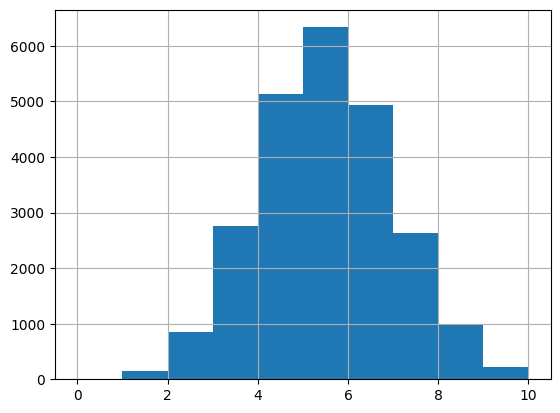

In [ ]:
pd.Series([len(text) for text in X_train_ind]).hist();

In [ ]:
seq_len = 10

features_train = np.zeros((len(X_train_ind), seq_len), dtype=int)
for i, text in enumerate(X_train_ind):
    if len(text) <= seq_len:
        zeros = list(np.zeros(seq_len - len(text)))
        new = zeros + text
    else:
        new = text[: seq_len]
    features_train[i, :] = np.array(new)


features_val = np.zeros((len(X_val_ind), seq_len), dtype=int)
for i, text in enumerate(X_val_ind):
    if len(text) <= seq_len:
        zeros = list(np.zeros(seq_len - len(text)))
        new = zeros + text
    else:
        new = text[: seq_len]
    features_val[i, :] = np.array(new)

features_train

array([[   0,    0,    0, ...,  769, 3354, 4401],
       [   0,    0,    0, ..., 5864, 4164, 2464],
       [   0,    0,    0, ..., 1604, 2433, 2645],
       ...,
       [   0,    0, 6442, ..., 6304,  649, 6099],
       [   0,    0,    0, ...,  976,  599,  943],
       [   0,    0,    0, ..., 7310, 3252,  983]])

In [ ]:
X_val_ind[0]

[5118, 5440, 4807, 6450, 2190, 480]

In [ ]:
features_val[0]

array([   0,    0,    0,    0, 5118, 5440, 4807, 6450, 2190,  480])

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader


train_data = TensorDataset(torch.from_numpy(features_train), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(features_val), torch.from_numpy(y_val))

TypeError: expected np.ndarray (got Series)

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)

classes = le.classes_
y_train_le

array([ 4,  6,  1, ...,  0, 11,  6])

In [ ]:
train_data = TensorDataset(torch.from_numpy(features_train), torch.from_numpy(y_train_le))
test_data = TensorDataset(torch.from_numpy(features_val), torch.from_numpy(y_val_le))

In [ ]:
BATCH_SIZE = 128

train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE)


torch.manual_seed(1)
for data, y in train_loader:
    print(data[0])
    print(classes[y[0]])
    break

tensor([   0,    0,    0, 3321,  730, 4394, 3176, 3715,  373,  379])
Из жизни


In [ ]:
data.shape

torch.Size([128, 10])

#### Обучение нейросети

In [ ]:
def plot_learning_curves(history, metric='acc'):
    fig = plt.figure(figsize=(20, 7))

    plt.subplot(1,2,1)
    plt.title('Loss', fontsize=15)
    plt.plot(history['loss']['train'], label='train')
    plt.plot(history['loss']['test'], label='test')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()

    plt.subplot(1,2,2)
    plt.title(f'Метрика {metric}', fontsize=15)
    plt.plot(history[metric]['train'], label='train')
    plt.plot(history[metric]['test'], label='test')
    plt.ylabel('Loss', fontsize=15)
    plt.xlabel('Epoch', fontsize=15)
    plt.legend()
    plt.show()

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        torch.manual_seed(1)
        self.emb = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.emb(x)
        x = torch.mean(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x


net = Net(len(word2id), 100, len(classes))
net = net.to(device)
net

Net(
  (emb): Embedding(7629, 100)
  (fc): Linear(in_features=100, out_features=14, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

https://torchmetrics.readthedocs.io/en/v0.8.2/classification/f1_score.html

In [ ]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.5/869.5 kB 17.6 MB/s eta 0:00:00


In [ ]:
from torchmetrics import F1Score

target = torch.tensor([0, 2, 2, 0, 1, 2])
preds = torch.tensor([0, 2, 1, 0, 0, 1])

f1 = F1Score(num_classes=3, average='macro', task='multiclass')
f1(preds, target)

tensor(0.4333)

In [ ]:
from IPython.display import clear_output

def train(model, crit, optim,
          train_loader, test_loader,
          num_epochs=10, plot=False):

    history = {'loss': {'train': [], 'test': []},
               'f1': {'train': [], 'test': []}}

    f1 = F1Score(num_classes=len(classes), average='macro', task='multiclass').to(device)

    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        f1s_train = []
        f1s_val = []


        model.train(True)

        # на каждой "эпохе" делаем полный проход по данным
        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)
            optim.zero_grad()

            outputs = model(inputs)

            loss = crit(outputs, labels)

            loss.backward()
            optim.step()


            train_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            f1s_train.append(f1(y_pred, labels).cpu())



        # подсчитываем лоссы и сохраням в "историю"
        train_loss /= len(train_loader)
        train_f1 = sum(f1s_train) / len(f1s_train)
        history['loss']['train'].append(train_loss)
        history['f1']['train'].append(train_f1)

        model.train(False)
        # полностью проходим по валидационному датасету
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            outputs = model(X_batch)
            loss = crit(outputs, y_batch)
            val_loss += np.sum(loss.detach().cpu().numpy())
            _, y_pred = torch.max(outputs, 1)
            f1s_val.append(f1(y_pred, y_batch).cpu())

        # подсчитываем лоссы и сохраням в "историю"
        val_loss /= len(test_loader)
        val_f1 = sum(f1s_val) / len(f1s_val)

        history['loss']['test'].append(val_loss)
        history['f1']['test'].append(val_f1)

        if plot:
            clear_output()
            plot_learning_curves(history)

        if epoch % 10 == 0:
            print(f"Epoch {epoch + 1} of {num_epochs}")
            print(f"  train loss: {train_loss:.3f}" \
                  f"  test loss: {val_loss:.3f}"  \
                  f"  train f1: {train_f1 * 100:.2f}%" \
                  f"  test f1: {val_f1 * 100:.2f}%")


    return model, history

Epoch 1 of 50
  train loss: 2.502  test loss: 2.424  train f1: 6.56%  test f1: 7.37%
Epoch 11 of 50
  train loss: 1.214  test loss: 1.258  train f1: 57.18%  test f1: 55.84%
Epoch 21 of 50
  train loss: 0.757  test loss: 1.002  train f1: 72.74%  test f1: 64.28%
Epoch 31 of 50
  train loss: 0.556  test loss: 0.957  train f1: 80.20%  test f1: 68.04%
Epoch 41 of 50
  train loss: 0.430  test loss: 0.973  train f1: 84.57%  test f1: 68.54%


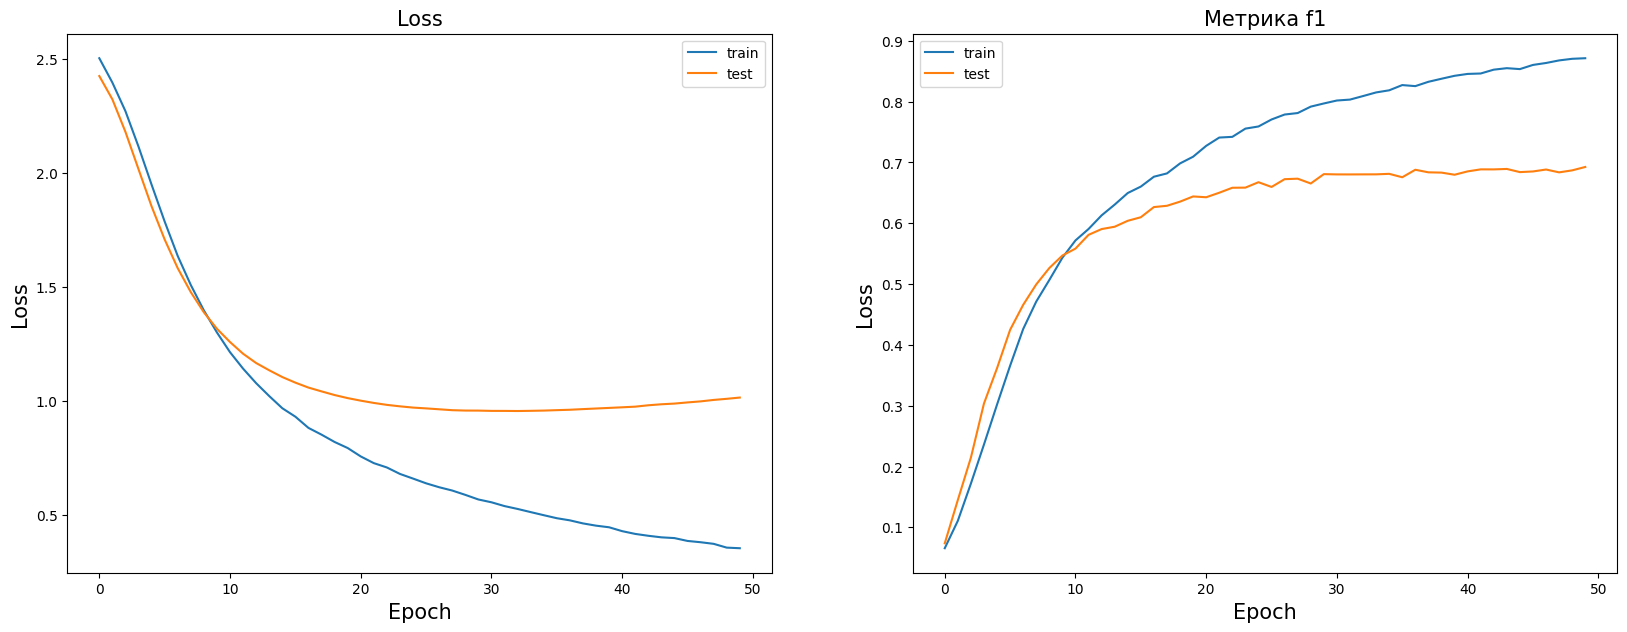

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

net, history = train(
    net, criterion, optimizer,
    train_loader, test_loader,
    num_epochs=50,
)

plot_learning_curves(history, 'f1')

## Дополнительные материалы
1. Метрики в torch https://torchmetrics.readthedocs.io/en/v0.8.2/index.html
2. Предобученные модели https://rusvectores.org/ru/models/
